In [1]:
import pandas as pd
import numpy as np

# Loading dataset
df = pd.read_csv('dataset.csv', usecols=[1,2,3,4], na_values=['nan', 'NaN'], header=None, skip_blank_lines=True)
df.columns = df.iloc[0]
df = df.drop([0])
df.dropna(inplace=True)
print(df)


0                                                  url  \
1    https://www.nscdscamps.org/blog/category/paren...   
2    https://howafrica.com/oscar-pistorius-attempts...   
3    http://washingtonsources.org/trump-votes-for-d...   
4    https://gloria.tv/video/yRrtUtTCfPga6cq2VDJPcgQe4   
5    http://blogs.trendolizer.com/2015/01/new-york-...   
6    https://web.archive.org/web/20171027105356/htt...   
7    https://web.archive.org/web/20170702174006/htt...   
8    http://beforeitsnews.com/opinion-conservative/...   
9    https://web.archive.org/web/20170731052757/htt...   
10   https://jis.gov.jm/president-trump-underscores...   
12   http://therightists.com/gretchen-carlson-the-2...   
13   https://web.archive.org/web/20180503143610/htt...   
14   http://www.breitbart.com/california/2017/10/17...   
15   https://www.politico.com/story/2017/05/09/trum...   
16   https://www.mirror.co.uk/news/us-news/there-bl...   
17   https://www.independent.co.uk/arts-entertainme...   
18   https://w

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

body_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')
title_vectorizer = TfidfVectorizer(strip_accents='ascii', stop_words='english')
skf = StratifiedKFold(n_splits=5, shuffle=True)
model = MultinomialNB()


# Prefixing function
def prefix(array, prefix):
    result = []
    spl_str = array
    for i in spl_str:
        pref_str = ''
        i = i.split()
        for x in i:
            pref_str = pref_str + (prefix + x) + ' '
        #pref_str = [pref_str]
        result.append(pref_str)
    return result


X = df['title']
y = df['label']
scores = []
for train_index, test_index in skf.split(X, y):
    # Train data
    train_title_array = np.array(df.iloc[train_index]['title'])
    train_title_array = prefix(train_title_array, 'title_')

    train_text_array = np.array(df.iloc[train_index]['text'])
    
    train_text_array = body_vectorizer.fit_transform(train_text_array)
    train_text_array = train_text_array.toarray()
    train_title_array = title_vectorizer.fit_transform(train_title_array)
    train_title_array = train_title_array.toarray()
    
    X_train = np.concatenate((train_title_array, train_text_array), axis=1)
    
    # Test data
    test_title_array = np.array(df.iloc[test_index]['title'])
    test_title_array = prefix(test_title_array, 'title_')
    
    test_text_array = np.array(df.iloc[test_index]['text'])
    test_text_array = body_vectorizer.transform(test_text_array)
    test_text_array = test_text_array.toarray()
    test_title_array = title_vectorizer.transform(test_title_array)
    test_title_array = test_title_array.toarray()
    
    X_test = np.concatenate((test_title_array, test_text_array), axis=1)

    
    # Labels: false = 0, real = 1
    y_train = np.array(df.iloc[train_index]['label']).astype(int)
    y_test = np.array(df.iloc[test_index]['label']).astype(int)
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    # Model 
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)
    test_proba = model.predict_proba(X_test)
    
    print('Accuracy score: ', accuracy_score(y_test, test_pred))
    print('Precision score: ', precision_score(y_test, test_pred))
    print('Recall score: ', recall_score(y_test, test_pred))
    print('F-1 score: ', f1_score(y_test, test_pred))
    print(classification_report(y_test, test_pred))

    scores.append(f1_score(y_test, test_pred))
    

print('Mean F1 Score: ', np.mean(scores))


Accuracy score:  0.6883116883116883
Precision score:  0.6758620689655173
Recall score:  0.98989898989899
F-1 score:  0.8032786885245902
             precision    recall  f1-score   support

          0       0.89      0.15      0.25        55
          1       0.68      0.99      0.80        99

avg / total       0.75      0.69      0.61       154

Accuracy score:  0.7450980392156863
Precision score:  0.7153284671532847
Recall score:  1.0
F-1 score:  0.8340425531914893
             precision    recall  f1-score   support

          0       1.00      0.29      0.45        55
          1       0.72      1.00      0.83        98

avg / total       0.82      0.75      0.70       153

Accuracy score:  0.6993464052287581
Precision score:  0.6805555555555556
Recall score:  1.0
F-1 score:  0.8099173553719008
             precision    recall  f1-score   support

          0       1.00      0.16      0.28        55
          1       0.68      1.00      0.81        98

avg / total       0.80     

In [22]:
# Preparing data for histogram

# put everything into one dataframe for ease of use
proba_df = pd.DataFrame(test_proba, columns=['false', 'true'])
accuracy_list = list(zip(test_pred, y_test))
df2 = pd.DataFrame(accuracy_list, columns=['prediction', 'ground_truth'])
proba_df = proba_df.join(df2)

x = 0
y_axis = []
for i in range(0, 9):
    proba_df_subset = proba_df[(x < proba_df['false']) & (proba_df['false'] < (x + 0.1)) 
                                                          & (proba_df['ground_truth'] == 0)]
    print(proba_df_subset)
    num = accuracy_score(proba_df_subset['ground_truth'], proba_df_subset['prediction'])
    y_axis.append(num)
    x += 0.1
    
class_prob = ['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']
    
print(y_axis)
print(class_prob)


       false      true  prediction  ground_truth
3   0.067208  0.932792           1             0
5   0.005350  0.994650           1             0
6   0.068894  0.931106           1             0
16  0.068990  0.931010           1             0
17  0.010394  0.989606           1             0
38  0.071956  0.928044           1             0
       false      true  prediction  ground_truth
0   0.146156  0.853844           1             0
8   0.197911  0.802089           1             0
9   0.155390  0.844610           1             0
22  0.140287  0.859713           1             0
23  0.104978  0.895022           1             0
25  0.169348  0.830652           1             0
26  0.172818  0.827182           1             0
30  0.144080  0.855920           1             0
35  0.133631  0.866369           1             0
36  0.127314  0.872686           1             0
37  0.125499  0.874501           1             0
39  0.108315  0.891685           1             0
49  0.166458  0.8335

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/function_base.py:356: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


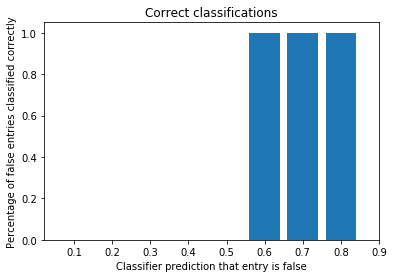

In [23]:
# Generating first histogram
import matplotlib.pyplot as plt
%matplotlib inline


n_bins = np.arange(len(class_prob))
plt.bar(n_bins, y_axis)
plt.xlabel('Classifier prediction that entry is false')
plt.ylabel('Percentage of false entries classified correctly')
plt.title('Correct classifications')
plt.xticks(n_bins, class_prob)

plt.show()

In [ ]:
#import math


'''
class_prob = []
for i in test_proba:
    class_prob.append(math.log(i[1]/i[0]))
'''